In [46]:
from keras.api.applications import EfficientNetB3
from keras import layers
import keras
import json
import pandas as pd
import tensorflow

In [47]:
BATCH_SIZE = 32
RESOLUTION = 300

trashnet = keras.utils.image_dataset_from_directory(
    "./data/trashnet",
    labels="inferred",
    label_mode="categorical",
    image_size=(RESOLUTION, RESOLUTION),
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.


In [48]:
augmentation_layers = [
    # Lighting variations
    layers.RandomBrightness(factor=(-0.2, 0.2)),
    # Blurring
    layers.GaussianNoise(stddev=0.1),
    # Distortions
    layers.RandomRotation(factor=0.1, fill_mode='nearest'),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='nearest'),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='nearest'),
    # Color variations
    layers.RandomContrast(factor=(0.8, 1.2)),
]

def augment(image):
    for layer in augmentation_layers:
        image = layer(image)
    return image

In [49]:
TRASHNET_CLASSES = 6

def preprocess(image, label):
    # label = tensorflow.one_hot(int(label), TRASHNET_CLASSES)
    image = augment(image)
    return image, label

training_dataset = trashnet.map(preprocess, num_parallel_calls=tensorflow.data.AUTOTUNE)
# training_dataset = training_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)
training_dataset = training_dataset.prefetch(tensorflow.data.AUTOTUNE)

In [50]:
inputs = layers.Input(shape=(RESOLUTION, RESOLUTION, 3))
model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze layers so we can train the top layers
model.trainable = False

# Recreate top layers
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2, name="top_dropout")(x)
outputs = layers.Dense(TRASHNET_CLASSES, activation="softmax", name="pred")(x)

# Compile model
model = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6340 - loss: 1.4713
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.7819 - loss: 1.1165
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7822 - loss: 1.1299
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7906 - loss: 1.1315
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.8150 - loss: 1.0187
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8229 - loss: 0.9908
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8068 - loss: 1.0380
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8239 - loss: 0.9380
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.8302 - loss: 0.8391
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8292 - loss: 0.8892


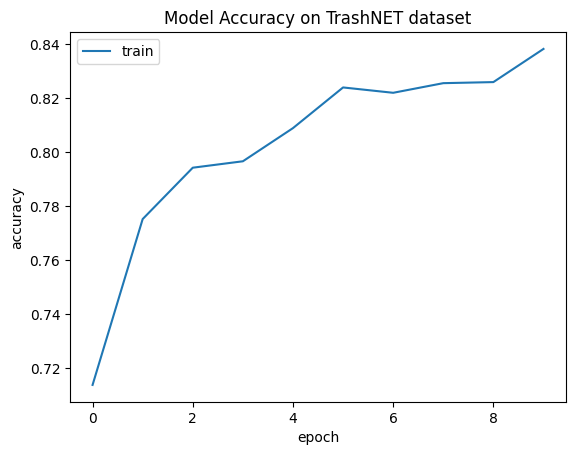

In [51]:
import matplotlib.pyplot as plt

epochs = 10
trained = model.fit(training_dataset, epochs=epochs)

def plot_results(data):
    plt.plot(data.history["accuracy"])
    plt.title("Model Accuracy on TrashNET dataset")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper left")
    plt.show()
    
plot_results(trained)